In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize

from consav import linear_interp

import Bargaining as brg

# plot style
linestyles = ['-','--','-.',':',':']
markers = ['o','s','D','*','P']
linewidth = 2
font_size = 17
font = {'size':font_size}
matplotlib.rc('font', **font)

plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

# c++ settings
do_cpp = True
do_compile = True
do_egm = True
threads = 16

In [2]:
# compile c++ files
if do_cpp & do_compile:
    model = brg.HouseholdModelClass(par={'do_cpp':do_cpp,'num_Ctot':100})
    model.link_to_cpp(force_compile=do_compile)
    model.cpp.delink()

# Solve and simulate from alternative models

In [3]:
# create a symmetric matrix with the highest values on the diagonal and values decreasing when moving through teh rows and colums
def create_asymmetric_matrix(n):
    A = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            A[i,j] = n - max(i,j)
    
    norm = A.sum(axis=0).reshape(-1,1)
    return A/norm

In [4]:
# settings for models to solve
T = 10
sigma = 0.1
num_love = 41
num_A = 50
num_A_pd = 50

uniform_mat = np.ones((num_A,num_A))/num_A
asym_mat = create_asymmetric_matrix(num_A)

settings = {'centered_gradient':True, 
       'p_meet': 0.1, 
       'div_A_share': 0.5, 
       'sigma_love':sigma,
       'T':T,'do_cpp':do_cpp,
       'threads':threads, 
       'interp_power':False,
       'num_love': num_love, 
       'do_egm':True, 
       'num_A': num_A_pd, 
       'num_A_pd':num_A_pd,}


specs = {
    'model 1':{'latexname':'Deterministic partner assets', 'par':{**settings,}},
    'model 2':{'latexname':'Stochastic partner assets, uniform', 'par':{**settings,'prob_partner_A_w':uniform_mat, 'prob_partner_A_m': uniform_mat,}},
    'model 3':{'latexname':'Stochastic partner assets', 'par':{**settings,'prob_partner_A_w':asym_mat, 'prob_partner_A_m': asym_mat,}},
}


In [5]:
# solve different models
models = {}
for name,spec in specs.items():
    print(f'solving {name}...')
    
    # setup model
    models[name] = brg.HouseholdModelClass(name=name,par=spec['par'])
    if do_cpp: models[name].link_to_cpp(force_compile=False)
    models[name].spec = spec
    
    # solve
    models[name].solve()

m1 = models['model 1']
m2 = models['model 2']
m3 = models['model 3']  

solving model 1...
solving model 2...
solving model 3...


In [6]:
# ## Re-compile and solve
# models['model 1'].cpp.delink()
# models['model 2'].cpp.delink()

# models['model 2'].link_to_cpp(force_compile=True)
# models['model 1'].link_to_cpp(force_compile=False)

# for name in models.keys():

#     print(f'solving {name}...')
#     models[name].allocate()
#     models[name].solve()

# m1 = models['model 1']
# m2 = models['model 2']

# Solution

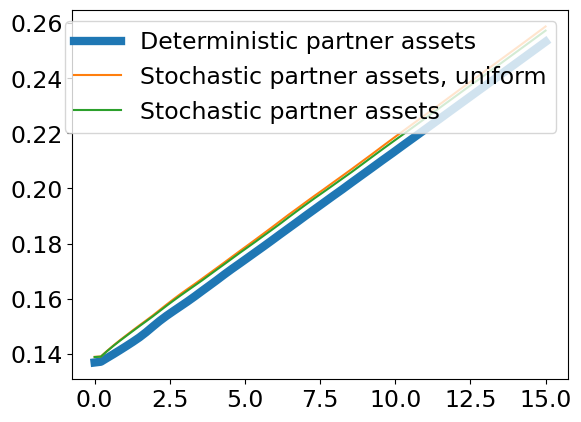

In [7]:
t = 0
iL = 20
iP = 5
var = "Cw_priv_couple_to_couple"

plt.plot(m1.par.grid_A, getattr(m1.sol,var)[t,iP,iL], label=m1.spec['latexname'], linewidth=6)
plt.plot(m2.par.grid_A, getattr(m2.sol, var)[t, iP, iL], label=m2.spec['latexname'])
plt.plot(m2.par.grid_A, getattr(m3.sol, var)[t, iP, iL], label=m3.spec['latexname'])
plt.legend()

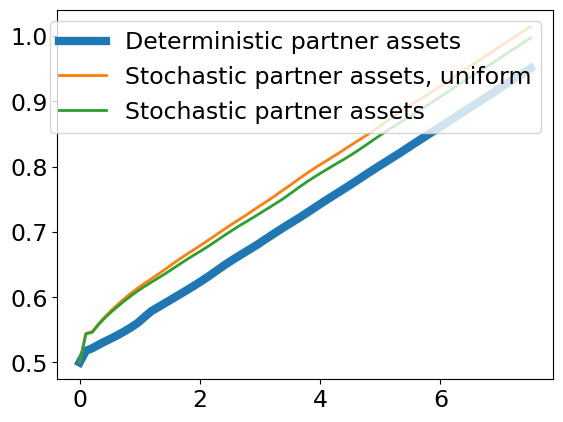

In [8]:
t = 0
var = "Cw_priv_single_to_single"
grid = "grid_Aw"

plt.plot(getattr(m1.par,grid),getattr(m1.sol,var)[t], linewidth=6, label=m1.spec['latexname'])
plt.plot(getattr(m2.par,grid),getattr(m2.sol, var)[t], linewidth=2,label=m2.spec['latexname'])
plt.plot(getattr(m2.par,grid),getattr(m3.sol, var)[t], linewidth=2,label=m3.spec['latexname'])
plt.legend()


### Simulation checks

In [35]:
for model in models.values():
    model.simulate()

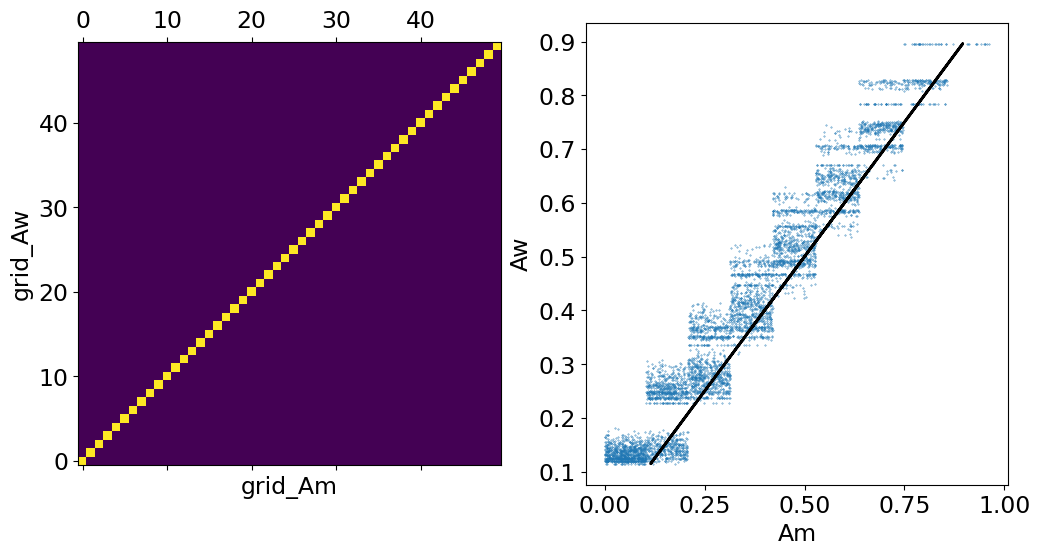

In [36]:
m = m1
# identify repartner
ones = np.ones(m.par.simN)
couple = np.column_stack((ones,m.sim.couple[:,:-1]))
single = couple == 0
meet_new = (m.sim.draw_meet < m.par.p_meet)
meet  = np.logical_and(meet_new, single)
o = np.zeros(m.par.simN, dtype=bool)
repartner = np.column_stack((o, np.diff(m.sim.couple) == 1))

Aw = m.sim.A_own[meet]
Ap = m.sim.A_partner[meet]


# make a plot
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
ax.matshow(m.par.prob_partner_A_w)
ax.set_xlabel('grid_Am')
ax.set_ylabel('grid_Aw')
ax.invert_yaxis()


ax = fig.add_subplot(1,2,2)
ax.scatter(Ap, Aw, s=0.1)
ax.set_xlabel('Am')
ax.set_ylabel('Aw')
ax.plot(m.sim.A_own[meet], m.sim.A_own[meet], color='black', linewidth=2);

(array([    8,    17,    27, ..., 49958, 49970, 49999], dtype=int64),)


Text(0.5, 1.0, 'Deterministic partner assets')

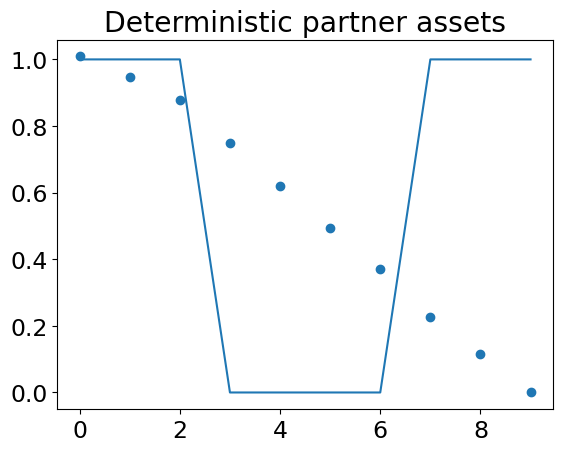

In [39]:
m = m1
i = 49999
print(np.where(np.diff(m.sim.couple).max(axis=1)))
plt.scatter(range(m.par.T),m.sim.Aw[i,:], label='Aw')
plt.plot(range(m.par.T),m.sim.couple[i,:], label='couple')
plt.title(m.spec['latexname'])

## Simulation

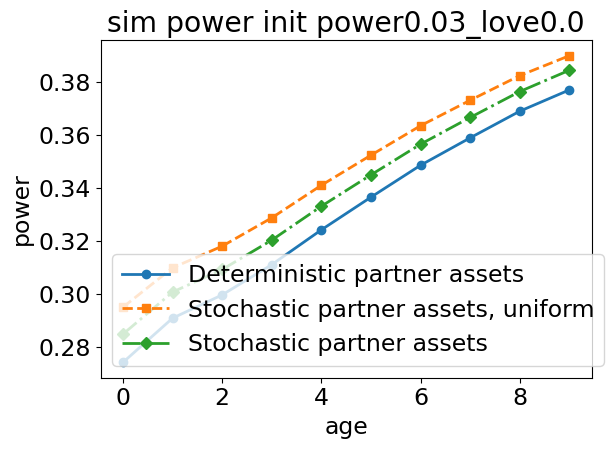

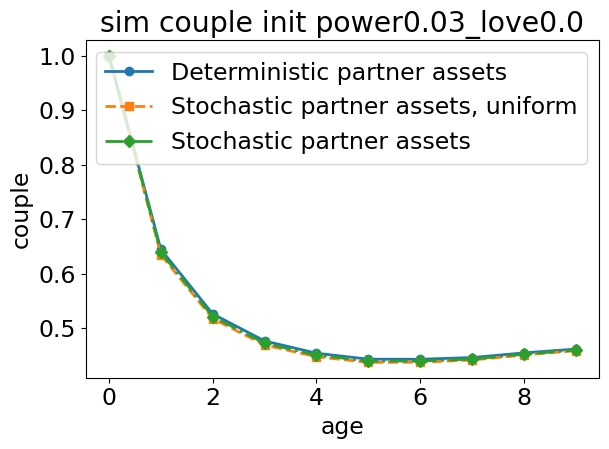

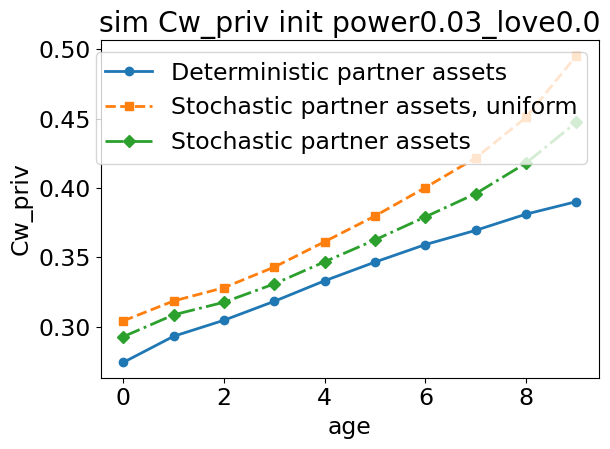

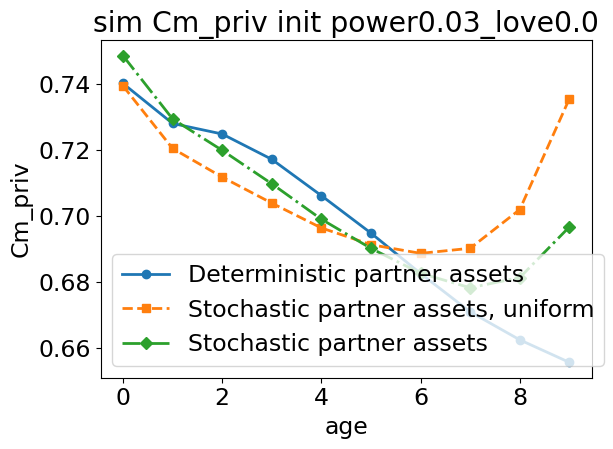

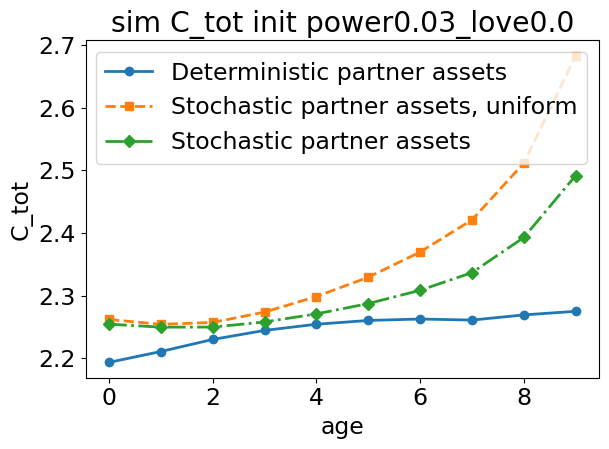

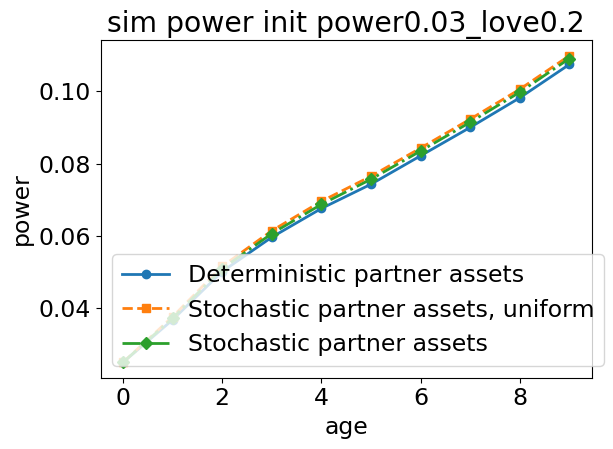

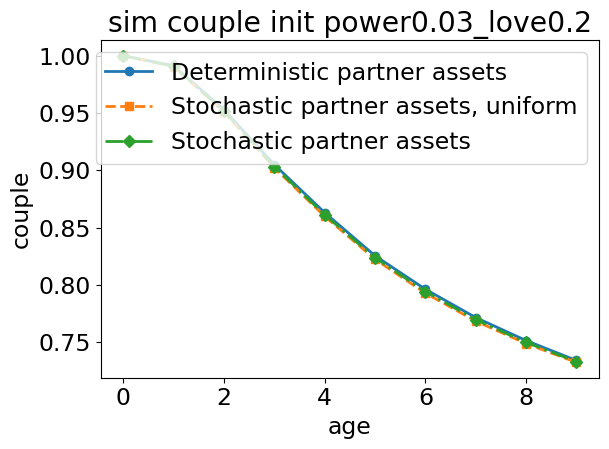

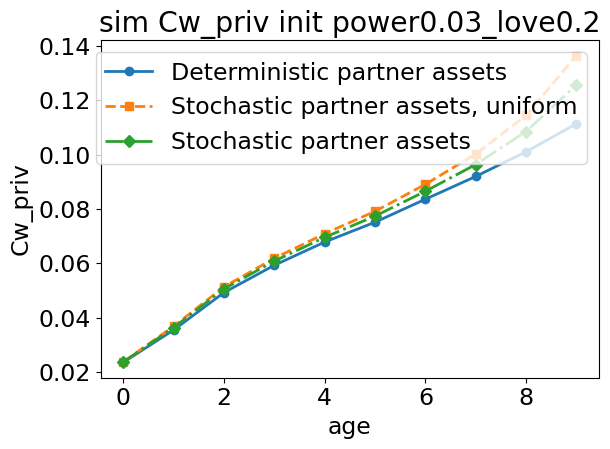

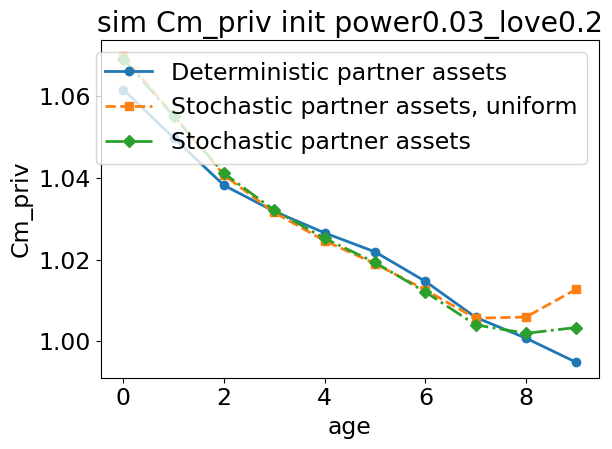

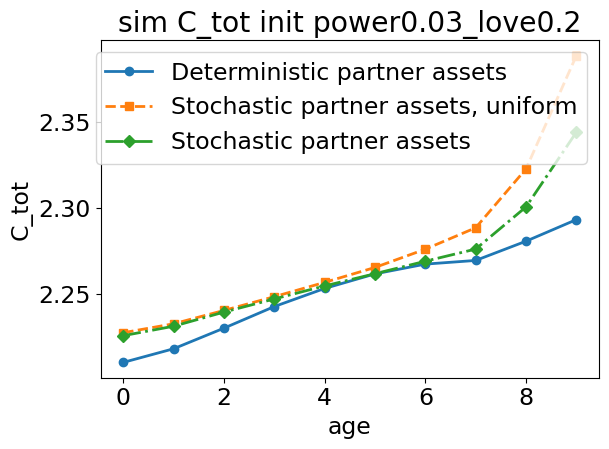

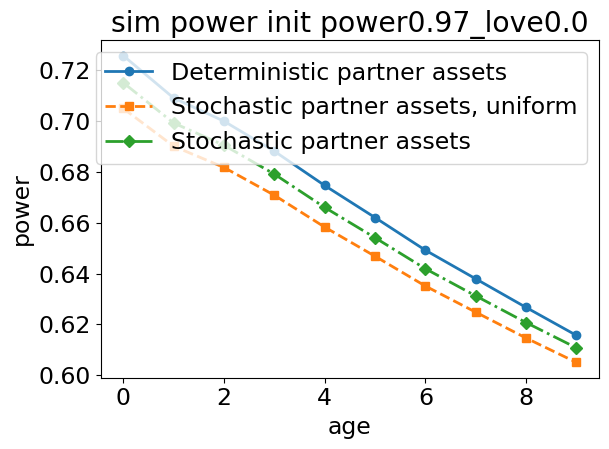

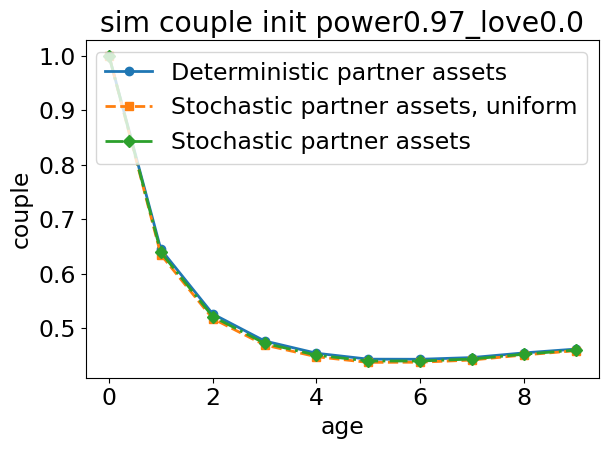

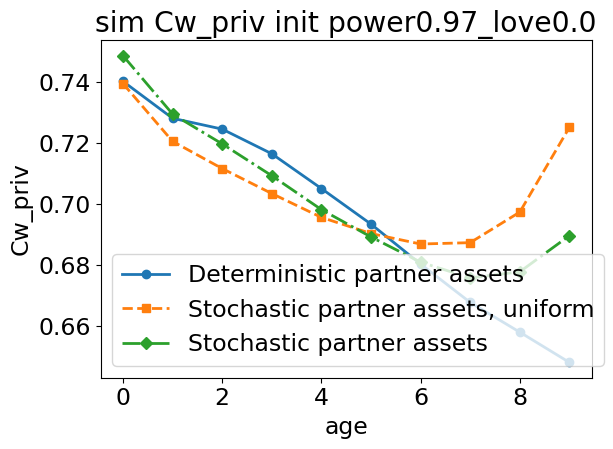

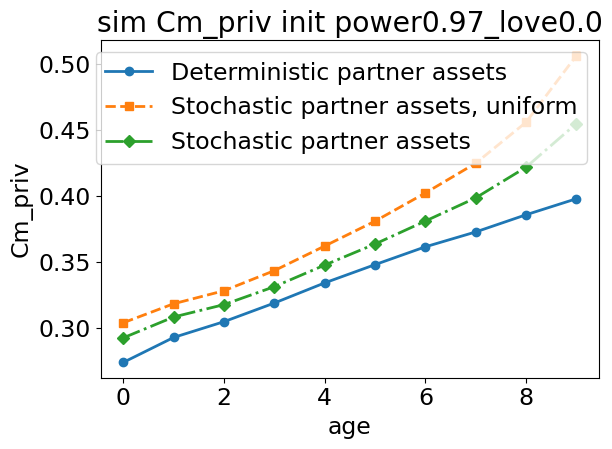

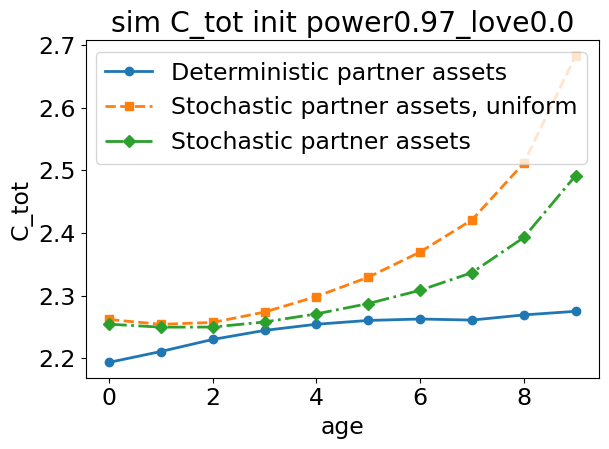

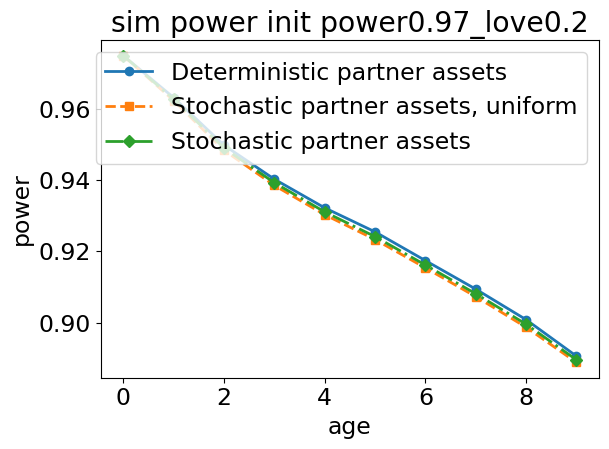

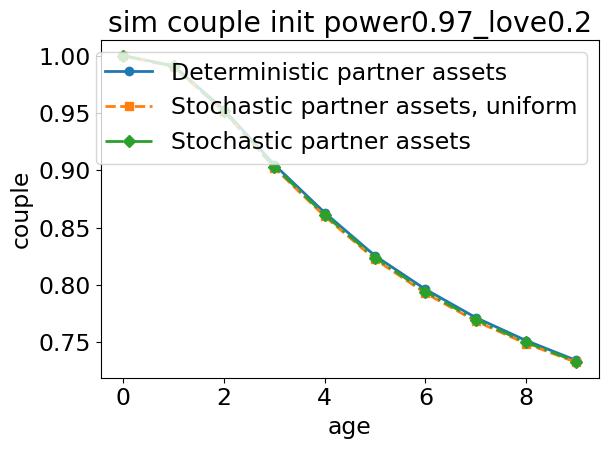

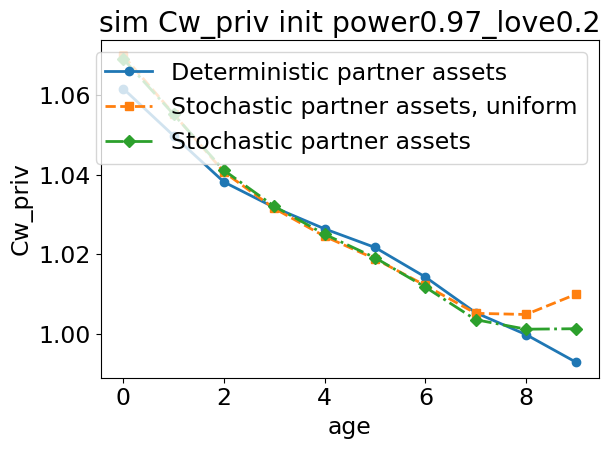

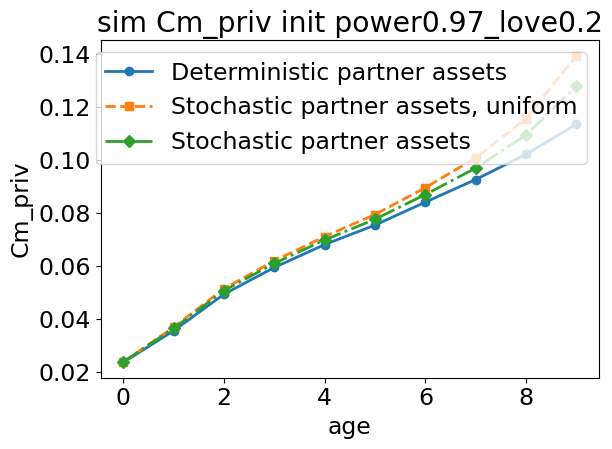

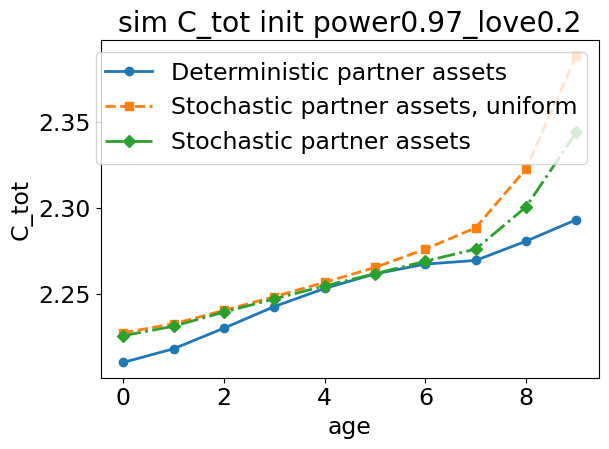

In [13]:
var_list = ('power','couple', 'Cw_priv', 'Cm_priv', 'C_tot')
model_list = ('model 1','model 2', 'model 3')
SAVE = False
for init_power_idx in (1, 19):
    for init_love in (0.0, 0.2): 

            for i,name in enumerate(model_list):
                model = models[name]

                # show how starting of in a low bargaining power gradually improves
                model.sim.init_power_idx[:] = init_power_idx
                model.sim.init_love[:] = init_love 
                model.simulate()
                
            for var in var_list:

                fig, ax = plt.subplots()
                
                for i,name in enumerate(model_list):
                    model = models[name]

                    # pick out couples (if not the share of couples is plotted)
                    if var == 'couple':
                        nan = 0.0
                    else:
                        I = model.sim.couple<1
                        nan = np.zeros(I.shape)
                        nan[I] = np.nan

                    # pick relevant variable for couples
                    y = getattr(model.sim,var)        
                    y = np.nanmean(y + nan,axis=0)

                    ax.plot(y,marker=markers[i],linestyle=linestyles[i],linewidth=linewidth,label=model.spec['latexname']);
                    ax.set(xlabel='age',ylabel=f'{var}');

                plt.legend()

                fig_name = f'sim {var} init power{np.round(model.par.grid_power[init_power_idx],2)}_love{init_love}'
                plt.title(fig_name)
                plt.tight_layout()
                if SAVE: plt.savefig(path+fig_name+'.pdf')

### Differences in simulated behavior...

In [14]:
model1 = models['model 1']
par1 = model1.par
sol1 = model1.sol
sim1 = model1.sim

model2 = models['model 2']
par2 = model2.par
sol2 = model2.sol
sim2 = model2.sim

init_A = 0.
init_love = 0.02
init_power_idx = 4
init_power = par1.grid_power[init_power_idx]

model1.sim.init_A[:] = init_A
model1.sim.init_love[:] = init_love
model1.sim.init_power_idx[:] = init_power_idx
model1.simulate()

model2.sim.init_A[:] = init_A
model2.sim.init_love[:] = init_love
model2.sim.init_power_idx[:] = init_power_idx
model2.simulate()

Sw1 = sol1.Vw_couple_to_couple-sol1.Vw_couple_to_single[:,np.newaxis, np.newaxis,:]
Sm1 = sol1.Vm_couple_to_couple-sol1.Vm_couple_to_single[:,np.newaxis, np.newaxis,:]

Sw2 = sol2.Vw_couple_to_couple-sol2.Vw_couple_to_single[:,np.newaxis, np.newaxis,:]
Sm2 = sol2.Vm_couple_to_couple-sol2.Vm_couple_to_single[:,np.newaxis, np.newaxis,:]

In [15]:
# interpolate spousal surplus for sim1
simSw1 = np.zeros((par1.simN,par1.simT))
simSm1 = np.zeros((par1.simN,par1.simT))
for i in range(par1.simN):
    for t in range(par1.simT):
        A = sim1.A[i,t]
        love = sim1.love[i,t]
        power = sim1.power[i,t]
        simSw1[i,t] = linear_interp.interp_3d(par1.grid_power,par1.grid_love,par1.grid_A,Sw1[t], power, love, A)
        simSm1[i,t] = linear_interp.interp_3d(par1.grid_power,par1.grid_love,par1.grid_A,Sm1[t], power, love, A)

# interpolate spousal surplus for sim2
simSw2 = np.zeros((par2.simN,par2.simT))
simSm2 = np.zeros((par2.simN,par2.simT))
for i in range(par2.simN):
    for t in range(par2.simT):
        A = sim2.A[i,t]
        love = sim2.love[i,t]
        power = sim2.power[i,t]
        simSw2[i,t] = linear_interp.interp_3d(par2.grid_power,par2.grid_love,par2.grid_A,Sw2[t], power, love, A)
        simSm2[i,t] = linear_interp.interp_3d(par2.grid_power,par2.grid_love,par2.grid_A,Sm2[t], power, love, A)

In [16]:
A = sim1.A[0,0]
power = sim1.power[0,0]

sol_power = np.zeros(par1.num_love)
for iP in range(par1.num_love):
    love = par1.grid_love[iP]
    sol_power[iP] = linear_interp.interp_3d(par1.grid_power,par1.grid_love,par1.grid_A,sol1.power[1], power, love, A)

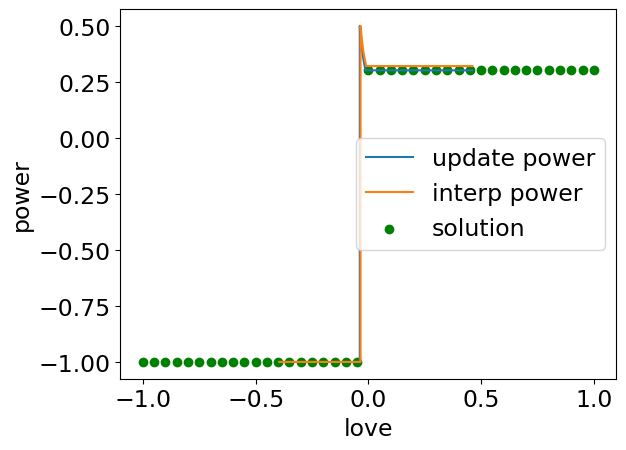

In [17]:
I1 = np.argsort(sim1.love[:,1])
I2 = np.argsort(sim2.love[:,1])

plt.plot(sim1.love[I1,1], sim1.power[I1,1], label='update power')
plt.plot(sim2.love[I2,1], sim2.power[I2,1], label='interp power')
plt.scatter(par1.grid_love, sol_power, color='green', label='solution')

# label axes
plt.xlabel('love')
plt.ylabel('power')
plt.legend();

(-0.2, -0.05)

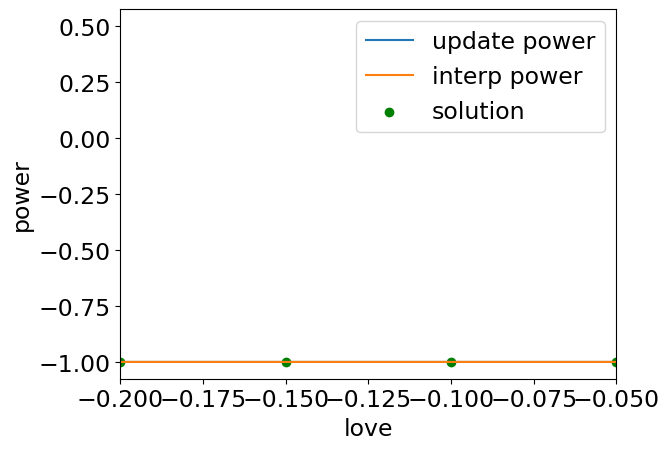

In [18]:
I1 = np.argsort(sim1.love[:,1])
I2 = np.argsort(sim2.love[:,1])


plt.plot(sim1.love[I1,1], sim1.power[I1,1], label='update power')
plt.plot(sim2.love[I2,1], sim2.power[I2,1], label='interp power')
plt.scatter(par1.grid_love, sol_power, color='green', label='solution')

# label axes
plt.xlabel('love')
plt.ylabel('power')
plt.legend()

# limit x axis
plt.xlim([-0.2,-0.05])

### Time

In [19]:
%timeit models['model 1'].simulate()
%timeit models['model 2'].simulate()

64.9 ms ± 3.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
63.4 ms ± 4.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
